# Machine learning using keras 
- Recognize expressions from people's face
- Input pixels: 48*48, black and white pictures
- Output: Angry, Fear, Happy, Sad, Surprise, Neutral


In [2]:
import os
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models
from tensorflow.keras import layers

Declare variables

In [3]:
num_expressions = 6
img_size = 48
data = pd.read_csv('../input/facial-expression/fer2013.csv')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Presenting data
View data structure

In [4]:
print(data.head(10))
print(data.shape)
print(data.Usage.value_counts())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training
6        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...  Training
7        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...  Training
8        3  85 84 90 121 101 102 133 153 153 169 177 189 1...  Training
9        2  255 254 255 254 254 179 122 107 95 124 149 150...  Training
(35887, 3)
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


# get rid of disgust

In [5]:
def add_one(x):
    if x>1:
        x=x-1
    return x

data = data[data['emotion']!=1]
data['emotion'] = data['emotion'].apply(add_one)

print(data.head(10))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        1  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        3  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        5  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
5        1  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training
6        3  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...  Training
7        2  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...  Training
8        2  85 84 90 121 101 102 133 153 153 169 177 189 1...  Training
9        1  255 254 255 254 254 179 122 107 95 124 149 150...  Training


Check emotions data

In [6]:
emotion_map = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
print(emotion_counts)

    emotion  number
0     Angry    4953
1      Fear    5121
2     Happy    8989
3       Sad    6077
4  Surprise    4002
5   Neutral    6198


View sample picture

In [7]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(img_size, img_size)
    image = np.zeros((img_size, img_size, 3))
    image[:, :, 0] = img
    image[:, :, 1] = img
    image[:, :, 2] = img
    return np.array([image.astype(np.uint8), emotion])


# show sample emotion expressions from dataset
def showFace(index):
    plt.figure(0, figsize=(16, 10))
    for i in range(1, 7):
        face = data[data['emotion'] == i - 1].iloc[index]
        img = row2image(face)
        plt.subplot(2, 3, i)
        plt.imshow(img[0])
        plt.title(img[1])
    plt.show()

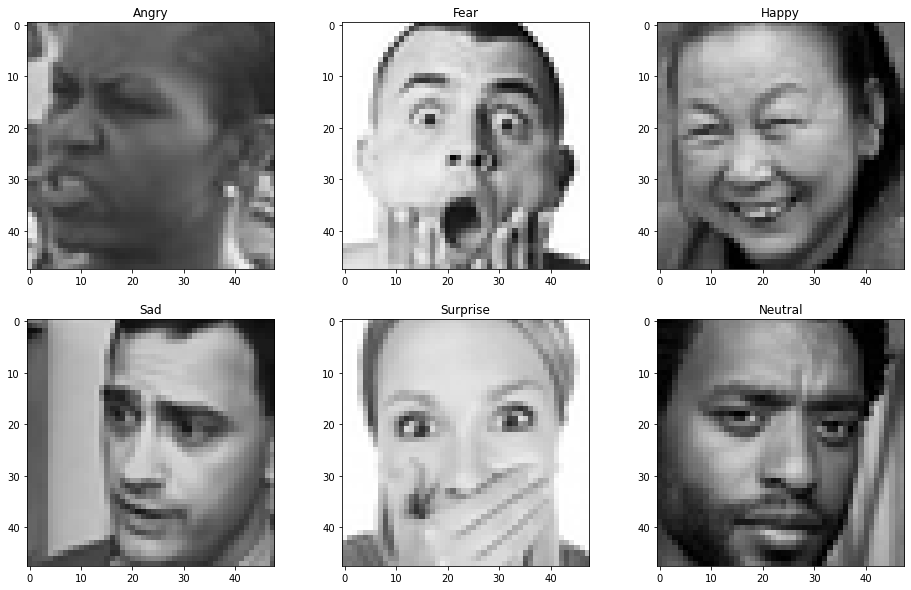

In [8]:
showFace(19)

## Pre-processing data
Split data to training, validation and testing set

In [9]:
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()

Normalize data

In [10]:
def CRNO(df, name):
    # convert pixels strings to integer lists
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    # to image, reshape and normalize grayscale
    x = np.array(df['pixels'].tolist()).reshape(-1, img_size, img_size, 1) / 255.0
    y = keras.utils.to_categorical(df['emotion'], num_expressions)
    print(name, "_X shape: {}, ", name, "_Y shape: {}".format(x.shape, y.shape))
    return x, y

In [11]:
train_X, train_Y = CRNO(data_train, "train")  # training data
val_X, val_Y = CRNO(data_val, "val")  # validation data
test_X, test_Y = CRNO(data_test, "test")  # test data

train _X shape: {},  train _Y shape: (28273, 48, 48, 1)
val _X shape: {},  val _Y shape: (3533, 48, 48, 1)
test _X shape: {},  test _Y shape: (3534, 48, 48, 1)


# Make a model

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(num_expressions))

# model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training

In [24]:
# data generator
data_generator = keras.preprocessing.image.ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, verbose=1, mode = 'min', restore_best_weights=True)

history = model.fit(data_generator.flow(train_X, train_Y, 128), batch_size=128, epochs=100, shuffle=True, callbacks = [es], validation_data=(val_X, val_Y)) 
# history = model.fit(train_X, train_Y, epochs=50, batch_size=128, validation_data=(val_X, val_Y), callbacks = [es], shuffle=True)

Epoch 1/100
221/221 [==============================] - 15s 68ms/step - loss: 1.0706 - accuracy: 0.5925 - val_loss: 1.0145 - val_accuracy: 0.6091
Epoch 2/100
221/221 [==============================] - 15s 69ms/step - loss: 1.0676 - accuracy: 0.5895 - val_loss: 1.0156 - val_accuracy: 0.6122
Epoch 3/100
221/221 [==============================] - 15s 66ms/step - loss: 1.0685 - accuracy: 0.5919 - val_loss: 1.0079 - val_accuracy: 0.6111
Epoch 4/100
221/221 [==============================] - 16s 73ms/step - loss: 1.0701 - accuracy: 0.5888 - val_loss: 1.0015 - val_accuracy: 0.6156
Epoch 5/100
221/221 [==============================] - 15s 68ms/step - loss: 1.0591 - accuracy: 0.5932 - val_loss: 1.0193 - val_accuracy: 0.6080
Epoch 6/100
221/221 [==============================] - 15s 69ms/step - loss: 1.0625 - accuracy: 0.5913 - val_loss: 1.0183 - val_accuracy: 0.6134
Epoch 7/100
221/221 [==============================] - 15s 67ms/step - loss: 1.0601 - accuracy: 0.5955 - val_loss: 1.0044 - val_ac

# Testing

111/111 - 0s - loss: 0.9532 - accuracy: 0.6327
0.6327108144760132


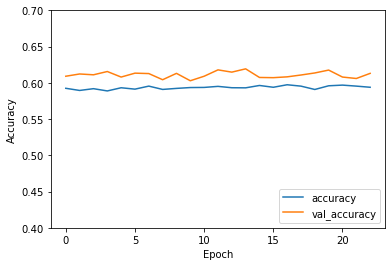

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 0.7])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_X,  test_Y, verbose=2)
print(test_acc)


# Save model

In [26]:
model.save('saved_model/my_model')  

In [27]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

test_loss, test_acc = new_model.evaluate(test_X,  test_Y, verbose=2)
print(test_acc)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          3